**IMPORT LIBRARY & LOAD DATA**

In [1]:
#Standard Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

#Deeplearning Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Additional
from collections import Counter
import pickle


Load data from my own drive. Please upload data to your drive first. You can get the data here: https://drive.google.com/drive/folders/1ZUKlJRVNA7LlOpWMZFkSElPakjZWG6bZ?usp=sharing

In [2]:
#Mounting drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
#Load data
df_train = pd.read_csv('../gdrive/MyDrive/emotion_detection/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('../gdrive/MyDrive/emotion_detection/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('../gdrive/MyDrive/emotion_detection/val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

**EXPLANATORY ANALYSIS**

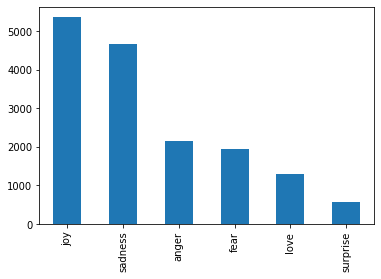

In [4]:
df_train.Sentiment.value_counts().plot.bar()

As you can see, the number of data with "Surprise" label is quite small (<1000). It will affect the result (and it is indeed, because i've tried it several times before, and the confusion rate for "Surprise" class is quite high). Therefore, I will cut it from all the data.

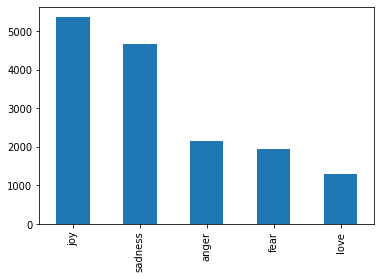

In [5]:
df_train = df_train[df_train.Sentiment != "surprise"].reset_index()
df_val = df_val[df_val.Sentiment != "surprise"].reset_index()
df_test = df_test[df_test.Sentiment != "surprise"].reset_index()

df_train.Sentiment.value_counts().plot.bar()

In [6]:
df_train.head(10)

,index,Input,Sentiment
0,0,i didnt feel humiliated,sadness
1,1,i can go from feeling so hopeless to so damned...,sadness
2,2,im grabbing a minute to post i feel greedy wrong,anger
3,3,i am ever feeling nostalgic about the fireplac...,love
4,4,i am feeling grouchy,anger
5,5,ive been feeling a little burdened lately wasn...,sadness
6,7,i feel as confused about life as a teenager or...,fear
7,8,i have been with petronas for years i feel tha...,joy
8,9,i feel romantic too,love
9,10,i feel like i have to make the suffering i m s...,sadness


Convert Category to Integer

In [7]:
df_train['sent_cat']=df_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4})
df_val['sent_cat']=df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4})
df_test['sent_cat']=df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4})

x_train = df_train['Input']
y_train = df_train['sent_cat']

x_val = df_val['Input']
y_val = df_val['sent_cat']

x_test = df_test['Input']
y_test = df_test['sent_cat']

**DATA VECTORIZATION**

In [8]:
#Check optimum sentence length
def check_length(x):
  lst=[]
  for i in x:
    lst.append(len(i))
    len1=pd.DataFrame(lst)
  return len1.describe()
check_length(x_train)

,0
count,15428.000000
mean,96.666710
std,55.848488
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


In [9]:
#Calculate number of unique words
words_list = []
for value in df_train.Input.str.split(' '):
    words_list.extend(value)
count_words = Counter(words_list)
len(count_words)

14917

With that information, we will go with 120 sentence length and 15000 vocabulary size

In [10]:
VOCABULARY_SIZE = 15000
EMBEDDING_DIM = 32
MAX_LENGTH = 120
PADDING_TYPE = "post"
TRUNC_TYPE = "post"

In [11]:
tokenizer = Tokenizer(num_words = VOCABULARY_SIZE)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [12]:
#Tokenize data
x_train_tkn=tokenizer.texts_to_sequences(x_train)
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_tkn, maxlen = MAX_LENGTH, padding = PADDING_TYPE, truncating = TRUNC_TYPE)

x_val_tkn=tokenizer.texts_to_sequences(x_val)
x_val_pad = tf.keras.preprocessing.sequence.pad_sequences(x_val_tkn, maxlen = MAX_LENGTH, padding = PADDING_TYPE, truncating = TRUNC_TYPE)

x_test_tkn=tokenizer.texts_to_sequences(x_test)
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_tkn, maxlen = MAX_LENGTH, padding = PADDING_TYPE, truncating = TRUNC_TYPE)

In [13]:
x_test_pad

array([[   16,     7,   201, ...,     0,     0,     0],
       [   16, 12526,    10, ...,     0,     0,     0],
       [    1,   142,    78, ...,     0,     0,     0],
       ...,
       [    1,     2,     8, ...,     0,     0,     0],
       [   16,     7,    37, ...,     0,     0,     0],
       [    1,     2,    35, ...,     0,     0,     0]], dtype=int32)

**CREATE MODEL**

In [14]:
model2= tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length = MAX_LENGTH))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120, return_sequences=True)))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(240)))
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(5, activation= 'softmax'))
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           480000    
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 240)          146880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 480)               923520    
_________________________________________________________________
dense (Dense)                (None, 64)                30784     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,581,509
Trainable params: 1,581,509
Non-trainable params: 0
______________________________________________

In [15]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [16]:
checkpoint_filepath = '../gdrive/MyDrive/emotion_detection/cp.ckpt"'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
model2.save_weights(checkpoint_filepath.format(epoch=0))

In [18]:
history2 = model2.fit(x_train_pad, y_train, epochs=15, validation_data=(x_val_pad, y_val), validation_steps=30, callbacks=[model_checkpoint_callback])

Epoch 1/15
483/483 [==============================] - 28s 35ms/step - loss: 1.1587 - accuracy: 0.5323 - val_loss: 0.8044 - val_accuracy: 0.7056
Epoch 2/15
483/483 [==============================] - 16s 33ms/step - loss: 0.4269 - accuracy: 0.8541 - val_loss: 0.2738 - val_accuracy: 0.9098
Epoch 3/15
483/483 [==============================] - 16s 34ms/step - loss: 0.1994 - accuracy: 0.9380 - val_loss: 0.2139 - val_accuracy: 0.9239
Epoch 4/15
483/483 [==============================] - 16s 34ms/step - loss: 0.1267 - accuracy: 0.9596 - val_loss: 0.2021 - val_accuracy: 0.9328
Epoch 5/15
483/483 [==============================] - 16s 33ms/step - loss: 0.0983 - accuracy: 0.9669 - val_loss: 0.2623 - val_accuracy: 0.9260
Epoch 6/15
483/483 [==============================] - 16s 33ms/step - loss: 0.0672 - accuracy: 0.9785 - val_loss: 0.2094 - val_accuracy: 0.9343
Epoch 7/15
483/483 [==============================] - 16s 34ms/step - loss: 0.0516 - accuracy: 0.9828 - val_loss: 0.2123 - val_accuracy:

In [19]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 1.2156142481602727)

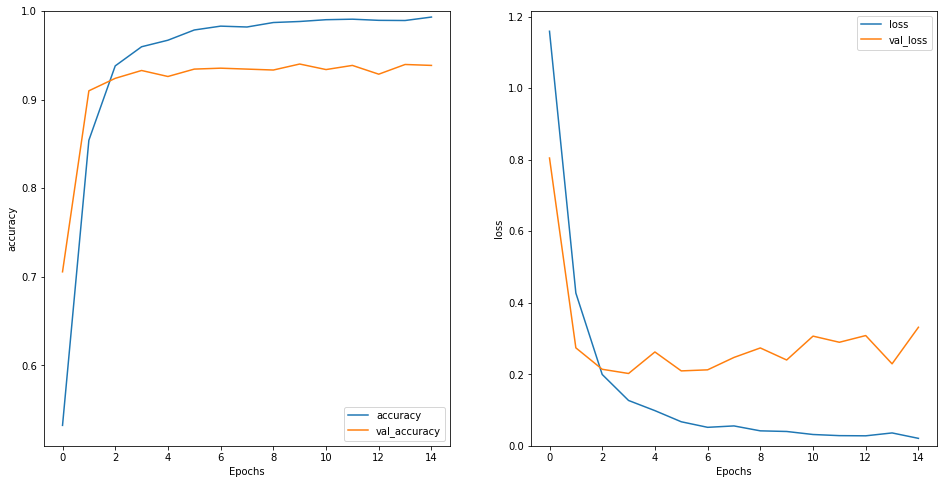

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')
plt.ylim(0, None)

In [21]:
model2.evaluate(x_test_pad,y_test)

61/61 [==============================] - 1s 12ms/step - loss: 0.3238 - accuracy: 0.9354


[0.32375529408454895, 0.9353671073913574]

In [22]:
y_pred=(model2.predict(x_test_pad) > 0.5).astype("int32")
#To Label Encoding
y_pred = np.argmax(y_pred, axis =-1)
prediction = pd.DataFrame(data=y_pred, columns=['prediction'])

In [23]:
actual = y_test.to_frame()
actual['actual'] = actual['sent_cat']

check_result = actual.join(prediction, how='left')
check_result['sent_cat'] = check_result.sent_cat.replace({0:'joy',1:'anger',2:'love',3:'sadness',4:'fear'})
check_result

,sent_cat,actual,prediction
0,sadness,3,3
1,sadness,3,3
2,sadness,3,3
3,joy,0,0
4,sadness,3,3
...,...,...,...
1929,anger,1,1
1930,anger,1,1
1931,joy,0,0
1932,joy,0,0


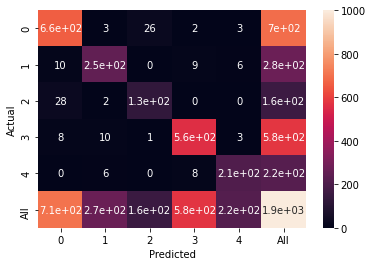

In [24]:
confusion_matrix = pd.crosstab(check_result['actual'], check_result['prediction'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True, vmin=0, vmax=1000)
plt.show()

**SAVE TOKENIZER AND MODEL**

In [25]:
#Tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
#Model
model2.save('../gdrive/MyDrive/emotion_detection/my_model.h5')

**RE-RUN FROM SAVED TOKENIZER AND MODEL**

In [27]:
#Load Tokenizer
tokenizer_path = '../gdrive/MyDrive/emotion_detection/tokenizer.pickle'
with open(tokenizer_path, 'rb') as handle:
    tokenizer_rerun = pickle.load(handle)

In [28]:
#Load Model checkpoint

model_rerun= tf.keras.models.load_model('../gdrive/MyDrive/emotion_detection/my_model.h5')

model_rerun.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           480000    
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 240)          146880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 480)               923520    
_________________________________________________________________
dense (Dense)                (None, 64)                30784     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,581,509
Trainable params: 1,581,509
Non-trainable params: 0
______________________________________________

In [29]:
#Retest
x_test_tkn=tokenizer_rerun.texts_to_sequences(x_test)
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_tkn, maxlen = 120, padding = 'post', truncating = 'post')

model_rerun.evaluate(x_test_pad,y_test)

61/61 [==============================] - 2s 14ms/step - loss: 0.3238 - accuracy: 0.9354


[0.32375529408454895, 0.9353671073913574]

In [30]:
#Emotion Response

joy = ["If you happy and you know it clap your hand! *clap* *clap* *clap*", 
       "Good thing that I wear sunglasses. Because you look so bright! B)",
       "So happy for you! Don't forget to spread your happiness to others!"]
    
sadness = ["It may sound even sadder, but an act of fake smiling can actually lift the mood.",
           "Every cloud has a silver lining. It is not a easy to be patient, but try it and good things will eventually come.",
           "It's always darkest before the dawn. I know it is hard, but try your best."]
    
anger = ["Sometimes anger is an effective solution. But most of the time, it isn't. Calm down, take a deep breath.",
         "If you are standing now, sit down for a while. If you are still angry after that, lay down for a while, take a deep breath.",
         "Forgive, when someone/something makes a mistake. Like we want to be forgiven when we make a mistake."]
    
love = ["Uuuu looks like someone is in love <3",
        "Are you having a fever? Your face is all red *smirk :)",
        "No wonder you are giggling all day!"]
    
fear = ["I can hear how scared you are. Try to reach someone close to you.",
        "It is normal to be afraid, try to reach someone close to you.",
        "It sounds hard. Try to reach someone close to you. Or try to do something else to free your mind from what bothers you."]
    
emotional_response = {"joy" : joy, "sadness":sadness, "anger": anger, "love": love, "fear": fear}

In [44]:
test= np.random.randint(0,3)
test

0

In [45]:
#Test Tokenizer
sample_text = "I am feeling so happy today"
sample_series = pd.Series(sample_text)
sample_tkn= tokenizer_rerun.texts_to_sequences(sample_series)
sample_pad = tf.keras.preprocessing.sequence.pad_sequences(sample_tkn, maxlen = 120, padding = "post", truncating = "post")
sample_pred=(model_rerun.predict(sample_pad) > 0.5).astype("int32")

In [47]:
#To Label Encoding
sample_pred = np.argmax(sample_pred, axis =-1)
prediction_sample = pd.DataFrame(data=sample_pred, columns=['prediction'])
prediction_sample['emotion'] = prediction_sample.prediction.replace({0:'joy',1:'anger',2:'love',3:'sadness',4:'fear'})
predicted_emo = prediction_sample.emotion[0]
predicted_emo

'joy'

In [48]:
#Response
index = np.random.randint(0,3)
response = emotional_response[predicted_emo][index]
response


'Good thing that I wear sunglasses. Because you look so bright! B)'